<a href="https://colab.research.google.com/github/poeala/CoderHouse-Data-Science-3/blob/main/Curso_CienciaDeDatosIII_proyecto_final_MariaLuzAndrade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Proyecto Final de NLP — Estructura y Guía de Implementación

ESTRUCTURA DEL TRABAJO solicitada

Descripción del problema de negocio.

Objetivo general

Origen de los datos

Definición de las variables.

Librerías a utilizar.

Desarrollo*(ETAPA 1 Y 2)

Conclusiones (Ejemplo: Insight, observaciones, resultados obtenidos, rechazo o no de una hipótesis).

Perspectivas futuras del proyecto.



## 1) Descripción del problema de negocio
> Clasificación de condición clínica (diagnóstico presuntivo por texto)

Qué resuelve: orientar el motivo de consulta a especialidad o protocolo (dermato, gastro, respiratorio, traumatología, urinario, conducta, etc.).
Columnas a usar:

Texto: text.

Etiqueta: condition como clase (multiclase).
Notebook:

ETAPA 1: nubes de palabras por condition para descubrir términos clave;

ETAPA 2: TF-IDF + clasificación multiclase (logística multinomial o SVM).
Salida práctica: derivación automática a profesional/box correcto, plantillas de indicaciones iniciales por condición.



## 2) Objetivo general
> Desarrollar un modelo de NLP que, a partir del campo text, clasifique automáticamente la condición clínica (condition) de cada consulta para orientar el caso a la especialidad/protocolo adecuado y acelerar la toma de decisiones.



## 3) Origen de los datos
- Fuente: Pet Health Symptoms Dataset  
- Link o ruta local: https://www.kaggle.com/datasets/yyzz1010/pet-health-symptoms-dataset?resource=download
-  Released under MIT License





## 4) Definición de las variables
Variables originales (del dataset):

text (string): descripción libre del motivo de consulta / síntomas escrita por el tutor.

Uso: variable principal sobre la que se aplican las técnicas de NLP (limpieza, tokenización, stopwords, stemming/lematización, n-gramas, TF-IDF).

condition (categoría): condición clínica asignada al registro (p. ej., dermatología, gastrointestinal, respiratorio, urinario, conducta, traumatología, etc.).

Uso (objetivo): variable objetivo multiclase del modelo de clasificación (diagnóstico presuntivo por texto).

record_type (categoría): tipo de registro (ej.: consulta inicial, seguimiento, posoperatorio, otro).

Uso: variable de contexto para análisis descriptivo; opcionalmente puede usarse para un modelo alternativo de clasificación del tipo de registro.


## 5) Librerías a utilizar


nltk, spacy, scikit-learn, wordcloud, matplotlib, pandas, numpy, vaderSentiment




In [23]:
import os, re, string, numpy as np, pandas as pd, matplotlib.pyplot as plt
from collections import Counter
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# NLTK
import nltk
for pkg in ["punkt", "stopwords", "gutenberg"]:
    try: nltk.data.find(f"tokenizers/{pkg}") if pkg=="punkt" else nltk.data.find(f"corpora/{pkg}")
    except LookupError: nltk.download(pkg, quiet=True)
try: nltk.data.find("tokenizers/punkt_tab")
except LookupError:
    try: nltk.download("punkt_tab", quiet=True)
    except Exception: pass

# spaCy (una sola vez)
import spacy
from spacy.cli import download as spacy_download
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    spacy_download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
english_stops = set(stopwords.words("english"))

from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.dummy import DummyClassifier



## 6) Carga del dataset
> CARGA DEL CORPUS DESDE KAGGLE



In [24]:
# Si kagglehub no funciona en tu entorno, admite CSV local: df = pd.read_csv("pet_health_symptoms.csv")
try:
    import kagglehub
    from pathlib import Path
    path = kagglehub.dataset_download("yyzz1010/pet-health-symptoms-dataset")
    csvs = list(Path(path).rglob("*.csv"))
    assert csvs, "No se encontraron CSV en el dataset descargado."
    # Elije un CSV que tenga la columna "text"
    def pick_csv(csv_paths):
        for p in csv_paths:
            try:
                cols = {c.lower() for c in pd.read_csv(p, nrows=5).columns}
                if "text" in cols: return p
            except Exception: pass
        return csv_paths[0]
    csv_path = pick_csv(csvs)
    df = pd.read_csv(csv_path)
except Exception as e:
    print("Fallo descarga automática. Cargá el CSV manualmente. Error:", e)
    # df = pd.read_csv("TU_ARCHIVO.csv")

df.columns = [c.lower() for c in df.columns]
df = df.dropna(subset=["text", "condition"]).copy()

def basic_clean(s: str):
    s = str(s).lower()
    s = re.sub(r"http\S+|www\.\S+", " ", s)
    s = re.sub(r"[^a-z\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

df["text_clean"] = df["text"].apply(basic_clean)
print("Clases (top):")
print(df["condition"].value_counts().head(10))


Clases (top):
condition
Digestive Issues     400
Mobility Problems    400
Parasites            400
Ear Infections       400
Skin Irritations     400
Name: count, dtype: int64


## 7) Limpieza + N-gramas + Nubes

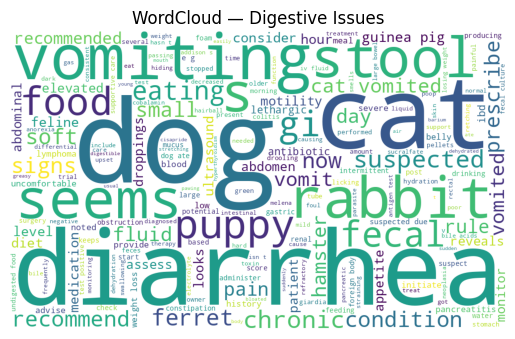

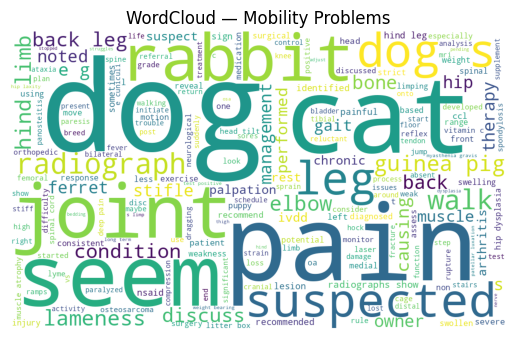

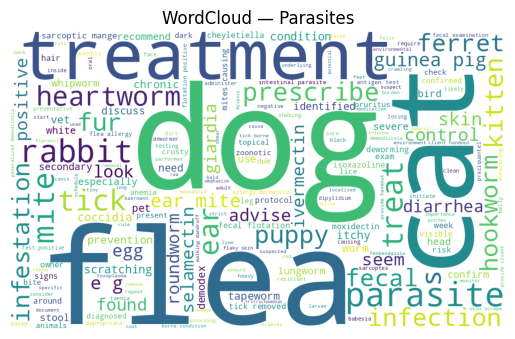

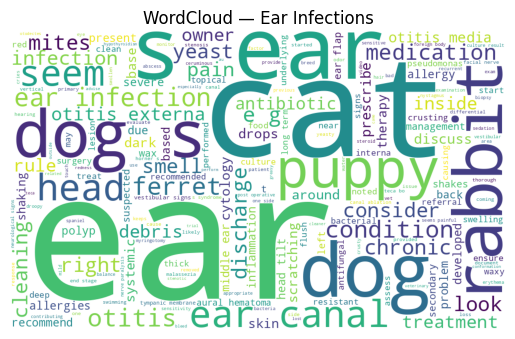

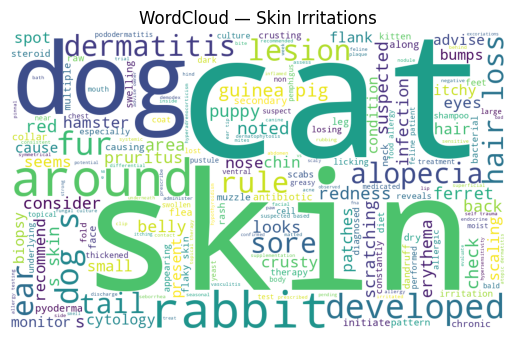


Top bigramas — Digestive Issues
           ngram  freq
0         my cat    30
1         my dog    28
2        dog has    24
3        cat has    17
4   has diarrhea    17
5      my rabbit    15
6       my puppy    12
7    cat vomited    11
8         dog is    10
9         due to    10
10    guinea pig    10
11      rule out    10
12  after eating     9
13     and seems     9
14        cat is     9

Top bigramas — Mobility Problems
               ngram  freq
0             my dog    80
1            dog has    30
2         guinea pig    16
3            cat has    15
4         rabbit has    13
5          back legs    11
6           his back    10
7          hind limb     9
8   radiographs show     9
9             cat is     8
10         hind legs     7
11            in his     7
12      suspected in     7
13          based on     6
14   consistent with     6

Top bigramas — Parasites
            ngram  freq
0         dog has    36
1          my dog    32
2          my cat    29
3         c

In [25]:
def basic_clean(s: str):
    s = s.lower()
    s = re.sub(r"http\S+|www\.\S+", " ", s)
    s = re.sub(r"[^a-z\s]", " ", s)  # si el corpus está en inglés
    s = re.sub(r"\s+", " ", s).strip()
    return s

df = df.dropna(subset=["text","condition"]).copy()
df["text_clean"] = df["text"].astype(str).apply(basic_clean)

# Nubes por clase (ajusta 'max_words' según tamaño)
for cls in df["condition"].value_counts().index[:6]:  # top 6 clases
    txt = " ".join(df.loc[df["condition"]==cls, "text_clean"])
    wc = WordCloud(width=1000, height=600, background_color="white").generate(txt)
    plt.figure(); plt.imshow(wc); plt.axis("off"); plt.title(f"WordCloud — {cls}"); plt.show()

# N-gramas (bigrams/trigrams) por clase
def top_ngrams(texts, ngram_range=(2,2), topk=15, min_df=2):
    vec = CountVectorizer(ngram_range=ngram_range, min_df=min_df)
    X = vec.fit_transform(texts)
    freqs = X.sum(axis=0).A1
    terms = vec.get_feature_names_out()
    pairs = sorted(zip(terms, freqs), key=lambda x: x[1], reverse=True)[:topk]
    return pd.DataFrame(pairs, columns=["ngram","freq"])

for cls in df["condition"].value_counts().index[:4]:
    print(f"\nTop bigramas — {cls}")
    print(top_ngrams(df.loc[df["condition"]==cls, "text_clean"], (2,2)))


## 8) Tokenización y remoción de stopwords (NLTK)
Primero un pipeline ligero con **NLTK**: tokenizamos a nivel de palabras


In [6]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Asegurar recursos necesarios
try:
    nltk.data.find("tokenizers/punkt")
except LookupError:
    nltk.download("punkt")

# En NLTK >= 3.9 también se requiere 'punkt_tab'
try:
    nltk.data.find("tokenizers/punkt_tab")
except LookupError:
    # Si existe, se descargará; si tu versión no lo tiene, no pasa nada.
    try:
        nltk.download("punkt_tab")
    except Exception:
        pass

try:
    nltk.data.find("corpora/stopwords")
except LookupError:
    nltk.download("stopwords")

english_stops = set(stopwords.words("english"))

# Si tienes lista de textos (corpus_texts):
sentences = corpus_texts

tokens = [tok for s in sentences for tok in word_tokenize(s, language="english")]
tokens_norm   = [t.lower() for t in tokens if any(ch.isalpha() for ch in t)]
tokens_no_stop = [t for t in tokens_norm if t not in english_stops]

print(f"# filas (oraciones): {len(sentences):,}")
print(f"# tokens crudos: {len(tokens):,}")
print(f"# tokens sin stopwords: {len(tokens_no_stop):,}")
tokens_no_stop[:40]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# filas (oraciones): 2,000
# tokens crudos: 23,586
# tokens sin stopwords: 14,350


['barium',
 'study',
 'performed',
 'evaluate',
 'motility',
 'rule',
 'partial',
 'obstruction',
 'assess',
 'deep',
 'pain',
 'sensation',
 'paralyzed',
 'limbs',
 'implement',
 'regular',
 'turning',
 'schedule',
 'padded',
 'bedding',
 'prevent',
 'pressure',
 'sores',
 'recumbent',
 'animals',
 'rule',
 'extra-gi',
 'causes',
 'vomiting',
 'renal',
 'condition',
 'pancreatitis',
 'dka',
 'baermann',
 'technique',
 'used',
 'recover',
 'lungworm',
 'larvae',
 'feces']


## 9) Lematización y POS‑tagging (spaCy)
Ahora usamos **spaCy** para lematizar y etiquetar categorías gramaticales (*Part‑of‑Speech*).

In [26]:
from spacy.cli import download as spacy_download

try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    spacy_download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

docs = list(nlp.pipe(sentences))

lemmas_no_stop = [
    [t.lemma_.lower() for t in doc if t.is_alpha and not t.is_stop]
    for doc in docs
]

pos_samples = [[(t.text, t.pos_) for t in doc[:12]] for doc in docs[:3]]
lemmas_no_stop[0][:20], pos_samples[0]


(['barium',
  'study',
  'perform',
  'evaluate',
  'motility',
  'rule',
  'partial',
  'obstruction'],
 [('Barium', 'NOUN'),
  ('study', 'NOUN'),
  ('performed', 'VERB'),
  ('to', 'PART'),
  ('evaluate', 'VERB'),
  ('motility', 'NOUN'),
  ('and', 'CCONJ'),
  ('rule', 'VERB'),
  ('out', 'ADP'),
  ('partial', 'ADJ'),
  ('obstruction', 'NOUN'),
  ('.', 'PUNCT')])

## 10) Comparar efectos del preprocesamiento
Observamos cómo cambian los tamaños del vocabulario con y sin lematización/stopwords.

In [28]:
sentences = df["text_clean"].tolist()

# Tokens planos (NLTK)
tokens = [tok for s in sentences for tok in word_tokenize(s, language="english")]
tokens_norm   = [t.lower() for t in tokens if any(ch.isalpha() for ch in t)]
tokens_no_stop = [t for t in tokens_norm if t not in english_stops]

# spaCy: lemas por documento
docs = list(nlp.pipe(sentences))
lemmas_no_stop = [
    [t.lemma_.lower() for t in doc if t.is_alpha and not t.is_stop]
    for doc in docs
]

# ✅ Corrección aquí (antes estaba mal):
flat_tokens_no_stop = tokens_no_stop                # ya es plano
flat_lemmas_no_stop = [l for sent in lemmas_no_stop for l in sent]

print("Top 20 tokens:", [w for w,_ in Counter(flat_tokens_no_stop).most_common(20)])
print("Top 20 lemas:",  [w for w,_ in Counter(flat_lemmas_no_stop).most_common(20)])


Top 20 tokens: ['dog', 'cat', 'ear', 'rabbit', 'skin', 'seems', 'ears', 'puppy', 'pain', 'ferret', 'suspected', 'diarrhea', 'e', 'mites', 'condition', 'guinea', 'pig', 'chronic', 'head', 'treatment']
Top 20 lemas: ['dog', 'ear', 'cat', 's', 'rabbit', 'skin', 'suspect', 'puppy', 'pain', 'recommend', 'ferret', 'flea', 'condition', 'infection', 'mite', 'cause', 'diarrhea', 'treatment', 'e', 'guinea']


## 11) Sentimiento (VADER)

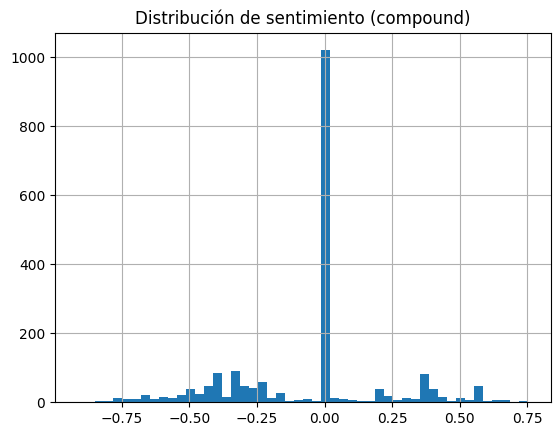

In [29]:
# !pip install -q vaderSentiment   # ideal: ponerlo en la 1ª celda si el entorno lo permite
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
df["sent_compound"] = df["text"].map(lambda s: analyzer.polarity_scores(s)["compound"])
df["sent_label"] = pd.cut(df["sent_compound"], bins=[-1.0,-0.05,0.05,1.0], labels=["neg","neu","pos"])
plt.figure(); df["sent_compound"].hist(bins=50); plt.title("Distribución de sentimiento (compound)"); plt.show()


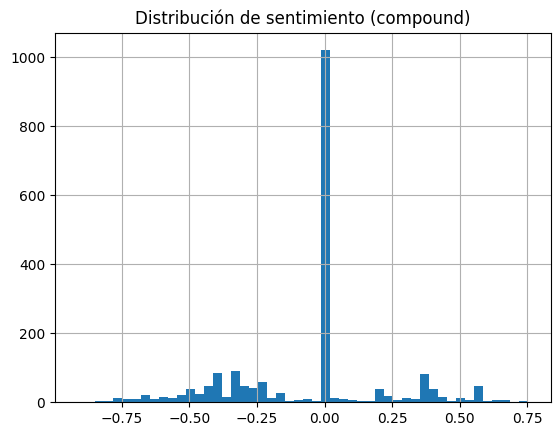

In [15]:
import matplotlib.pyplot as plt
plt.figure(); df["sent_compound"].hist(bins=50); plt.title("Distribución de sentimiento (compound)");

## 12) ETAPA 2: Pipeline + Modelo + Métricas

In [16]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.dummy import DummyClassifier

RANDOM_STATE = 42
X = df["text_clean"]
y = df["condition"].astype(str)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# Baseline
dummy = DummyClassifier(strategy="most_frequent").fit(X_train, y_train)
print("Baseline accuracy:", dummy.score(X_test, y_test))

# Pipeline TF-IDF + LR multinomial
clf = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), max_features=50000, min_df=2)),
    ("lr", LogisticRegression(max_iter=1000, multi_class="auto", class_weight="balanced", n_jobs=-1))
])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("\nClasification report (macro-F1 recomendado):\n",
      classification_report(y_test, y_pred, digits=3))
print("\nMatriz de confusión (shape:", confusion_matrix(y_test, y_pred).shape, ")")


Baseline accuracy: 0.2


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Clasification report (macro-F1 recomendado):
                    precision    recall  f1-score   support

 Digestive Issues      0.810     0.850     0.829        80
   Ear Infections      0.783     0.812     0.798        80
Mobility Problems      0.844     0.812     0.828        80
        Parasites      0.803     0.713     0.755        80
 Skin Irritations      0.741     0.787     0.764        80

         accuracy                          0.795       400
        macro avg      0.796     0.795     0.795       400
     weighted avg      0.796     0.795     0.795       400


Matriz de confusión (shape: (5, 5) )


In [17]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(
    clf,
    {"lr__C":[0.1, 1.0, 3.0]},
    scoring="f1_macro",
    cv=3,
    n_jobs=-1
)
grid.fit(X_train, y_train)
print("Mejor C:", grid.best_params_, "F1_macro (cv):", grid.best_score_)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Mejor C: {'lr__C': 3.0} F1_macro (cv): 0.7585602248626285



## 13) Representación **TF‑IDF** del corpus
Vectorizamos el texto por oraciones para inspeccionar términos relevantes.

In [18]:
# ====  TF-IDF (en inglés)  ====
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np

# Usamos oraciones/textos ya limpios (tu lista 'sentences')
sample_sents = sentences[:1000]  # recorta si es muy largo

# Opción A: stopwords internas de sklearn ('english')
vectorizer = TfidfVectorizer(
    lowercase=True,
    stop_words='english',     # también puedes usar tu lista: stop_words=list(english_stops)
    max_features=5000,
    ngram_range=(1, 2)
)

X = vectorizer.fit_transform(sample_sents)

# TF-IDF promedio por término (solo para ranking rápido)
tfidf = np.asarray(X.mean(axis=0)).ravel()
terms = np.array(vectorizer.get_feature_names_out())

top_idx = tfidf.argsort()[::-1][:30]
df_tfidf = pd.DataFrame({
    "term": terms[top_idx],
    "avg_tfidf": tfidf[top_idx]
})
df_tfidf


,term,avg_tfidf
0,dog,0.029264
1,cat,0.024109
2,ear,0.017776
3,rabbit,0.014800
4,ears,0.010910
5,skin,0.010730
6,ferret,0.010270
7,puppy,0.009227
8,guinea,0.008081
9,pig,0.008081




## 14)  Polaridad rápida (lexicón simple)
Para evitar dependencias pesadas, usamos un **lexicón mini** (positivo/negativo) y calculamos una polaridad simplificada:  
\( polarity = \frac{pos - neg}{pos + neg + 1e-6} \).  
**Nota:** Es solo demostrativo; para producción usa modelos específicos o léxicos amplios.


In [19]:
import nltk
from nltk.tokenize import word_tokenize

# Asegura recursos
try:
    nltk.data.find("tokenizers/punkt")
except LookupError:
    nltk.download("punkt", quiet=True)

# Mini lexicón (ajústalo a tu dominio)
lex_pos = {"good","excellent","happy","wonderful","joyful","kind","honest","beautiful","brave","friend","love"}
lex_neg = {"bad","horrible","sad","terrible","angry","cruel","ugly","coward","enemy","hate","pain"}

def polarity_score(sentence: str):
    toks = [t.lower() for t in word_tokenize(sentence, language="english") if any(ch.isalpha() for ch in t)]
    pos = sum(1 for t in toks if t in lex_pos)
    neg = sum(1 for t in toks if t in lex_neg)
    return (pos - neg) / (pos + neg + 1e-6)

examples = [
    "I am very happy and grateful for this wonderful day.",
    "It was a terrible experience and I feel angry.",
    "The wandering knight had a difficult yet brave journey."
]

for s in examples:
    print(f"{s}\n  polarity: {polarity_score(s):.3f}")


I am very happy and grateful for this wonderful day.
  polarity: 1.000
It was a terrible experience and I feel angry.
  polarity: -1.000
The wandering knight had a difficult yet brave journey.
  polarity: 1.000


## 15) Gráficos
Distribución de longitudes de oraciones y top términos TF‑IDF.

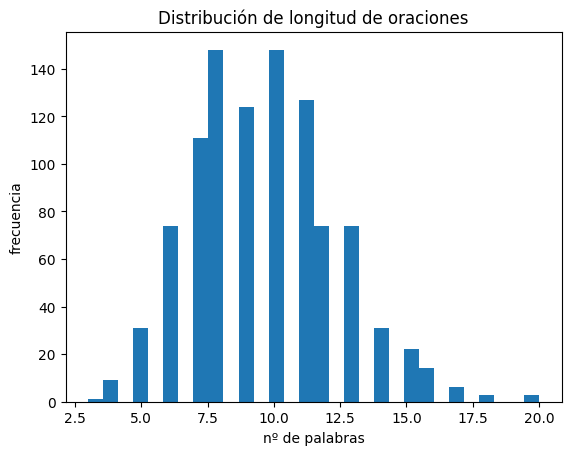

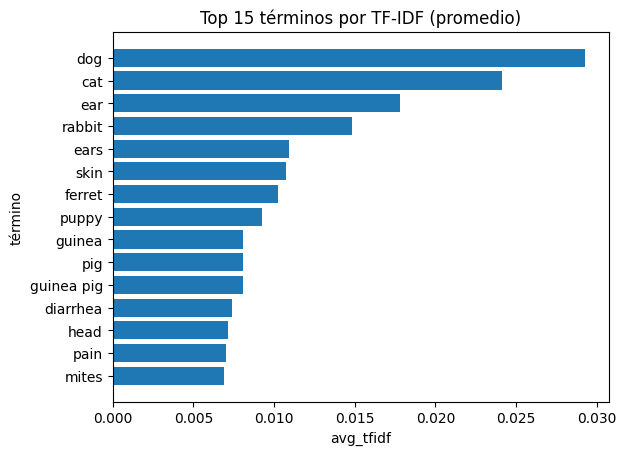

In [11]:
import matplotlib.pyplot as plt

lens = [len(s.split()) for s in sample_sents]

plt.figure()
plt.hist(lens, bins=30)
plt.title("Distribución de longitud de oraciones")
plt.xlabel("nº de palabras")
plt.ylabel("frecuencia")
plt.show()

plt.figure()
plt.barh(df_tfidf["term"].iloc[:15][::-1], df_tfidf["avg_tfidf"].iloc[:15][::-1])
plt.title("Top 15 términos por TF-IDF (promedio)")
plt.xlabel("avg_tfidf")
plt.ylabel("término")
plt.show()





## 16) Conclusiones (completa aquí)
- **Efecto de stopwords:** …  
- **Efecto de lematización:** …  
- **POS‑tagging (tendencias):** …  
- **TF‑IDF (términos relevantes):** …  
- **Polaridad:** …

**Sugerencias:** probar con otro corpus, comparar stemming vs lematización, cambiar n‑gramas en TF‑IDF y medir variaciones.
